<a href="https://colab.research.google.com/github/ssv273/Recom_systems/blob/master/Two_level_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install implicit

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier, plot_importance

import warnings
warnings.filterwarnings("ignore")

import os, sys
module_path_1 = '/content/drive/My Drive/Recomendation_systems/src'
module_path_2 = '/content/drive/My Drive/Recomendation_systems/'
if module_path_1 not in sys.path:
    sys.path.append(module_path_1)
if module_path_2 not in sys.path:
    sys.path.append(module_path_2)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [4]:
data = pd.read_csv('/content/drive/My Drive/Recomendation_systems/Data/retail_train.csv')
item_features = pd.read_csv('/content/drive/My Drive/Recomendation_systems/Data/product.csv')
user_features = pd.read_csv('/content/drive/My Drive/Recomendation_systems/Data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [5]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [6]:
recommender = MainRecommender(data_train_lvl_1)

In [7]:
def prep(data_train_lvl_2, data_train_lvl_1):
  # your_code

  users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
  users_lvl_2.columns = ['user_id']

  # Пока только warm start
  train_users = data_train_lvl_1['user_id'].unique()
  users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

  users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

  s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
  s.name = 'item_id'

  users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
  users_lvl_2['flag'] = 1

  targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
  targets_lvl_2['target'] = 1  # тут только покупки 

  targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

  targets_lvl_2.drop_duplicates()

  targets_lvl_2['target'].fillna(0, inplace= True)
  targets_lvl_2.drop('flag', axis=1, inplace=True)

  targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
  targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

  return targets_lvl_2

In [8]:
targets_lvl_2 = prep(data_train_lvl_2, data_train_lvl_1)

In [9]:
targets_lvl_2.shape, data_train_lvl_2.shape

((115495, 16), (169711, 12))

((115495, 16), (169711, 12))

In [10]:
targets_val_lvl_2 = prep(data_val_lvl_2, data_train_lvl_1)

# Фичи

In [11]:
big_data = data.merge(item_features, on='item_id', how='left')
big_data = big_data.merge(user_features, on='user_id', how='left')

In [12]:
big_data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0,2,PRODUCE,National,ONIONS,ONIONS SWEET (BULK&BAG),40 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Фичи товара

Кол-во покупок в неделю, среднее кол-во покупок в неделю по каждой категории товара

In [13]:
def feats_create(big_data, targets_lvl_2):

  # Для начала заменим категориальные значения на цифровые
  # Возраст
  targets_lvl_2['age'] = targets_lvl_2['age_desc'].replace(
        {'65+': 70, '45-54': 50, '25-34': 30, '35-44': 40, '19-24':20, '55-64':60})
  targets_lvl_2 = targets_lvl_2.drop('age_desc', axis=1)
  ##### Доход
  targets_lvl_2['income'] = targets_lvl_2['income_desc'].replace(
          {'35-49K': 45,
        '50-74K': 70,
        '25-34K': 30,
        '75-99K': 95,
        'Under 15K': 15,
        '100-124K': 120,
        '15-24K': 20,
        '125-149K': 145,
        '150-174K': 170,
        '250K+': 250,
        '175-199K': 195,
        '200-249K': 245}
      )
  targets_lvl_2 = targets_lvl_2.drop('income_desc', axis=1)


  # Кол-во покупок в неделю, среднее кол-во покупок в неделю по каждой категории товара  
  # создаем временный датафрейм, в котором будут значения количеств всех покупок по каждой категории
  temp_df = big_data.groupby('department').agg({'quantity' : 'sum'}).reset_index()
  # теперь делим количество покупок на количество недель и получаем среднее количество покупок в неделю для каждой категории товара
  temp_df['average_num_purchases_per_week'] = temp_df['quantity'] / big_data['week_no'].nunique()
  temp_df = temp_df.rename(columns={'quantity' : 'num_purchases_per_week'})
  # объединяем обучающий датасет и фичи по категориям 
  targets_lvl_2 = targets_lvl_2.merge(temp_df, on=['department'], how='left')

  # Средний чек
  temp_df = big_data[['user_id', 'basket_id', 'quantity', 'sales_value', 'department']]
  # считаем сумму по каждому товару
  temp_df['amount'] = temp_df['quantity'] * temp_df['sales_value']
  # получаем количество заказов пользователя и общую сумму всех заказов
  temp_df = temp_df.groupby(['user_id'])['basket_id'].count().reset_index().merge(
            temp_df.groupby(['user_id']).agg({'amount' : 'sum'}), on='user_id', how='left')
  temp_df['average_check'] = temp_df['amount'] / temp_df['basket_id']
  # объединяем обучающий датасет и фичи
  targets_lvl_2 = targets_lvl_2.merge(temp_df[['user_id', 'average_check']], on=['user_id'], how='left')

  # Кол-во покупок в каждой категории
  temp_df = big_data[['user_id', 'quantity', 'department']]
  # получаем количество покупок по каждой категории товара
  temp_df = temp_df.groupby(['user_id', 'department']).agg({'quantity' : 'sum'}).reset_index()
  temp_df = temp_df.rename(columns={'quantity' : 'num_purchases_each_department'})
  # объединяем обучающий датасет и фичи
  targets_lvl_2 = targets_lvl_2.merge(temp_df, on=['user_id', 'department'], how='left')

  # Фичи пары user_id - item_id

  #Средняя сумма покупки 1 товара в каждой категории
  temp_df= big_data[['user_id', 'item_id', 'department', 'quantity', 'sales_value']]
  # Создадим столбец сумма в которой получим сумму по каждому купленному товару
  temp_df['summ'] = temp_df['quantity'] * temp_df['sales_value']
  # считаем среднюю сумму покупки товара в каждой категории
  temp_df_1 = temp_df.groupby(['user_id', 'department']).agg({'summ' : 'mean'})\
              .rename(columns={'summ' : 'mean_summ'})\
              .reset_index()
  # Записываем среднюю сумму во временный датафрейм
  temp_df = temp_df.merge(temp_df_1, on=['user_id', 'department'], how='left')
  # Смотрим на сколько юзер купил меньше или больше товаров в каждой категории чем в среднем по категрии покупали все юзеры
  temp_df['price_item_minus_mean_summ'] = temp_df['sales_value'] - temp_df['mean_summ']
  # так как дальше не влезает в память выбросим юзеров и товары, которых нет в targets_lvl_2
  users_in_targets_lvl_2 = targets_lvl_2['user_id'].unique()
  items_in_targets_lvl_2 = targets_lvl_2['item_id'].unique()
  temp_df = temp_df[(temp_df['user_id'].isin(users_in_targets_lvl_2)) & (temp_df['item_id'].isin(items_in_targets_lvl_2))]
  # объединяем обучающий датасет и фичи
  targets_lvl_2 = targets_lvl_2.merge(temp_df, on=['user_id', 'department', 'item_id'], how='left')

  # (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
  temp_df_1 = big_data.groupby(['user_id', 'department', 'week_no']).agg({'quantity' : 'mean'})\
                      .reset_index()\
                      .rename(columns={'quantity' : 'sum_quantity_per_week_per_user_per_dept'})
  temp_df_2 = big_data.groupby(['department', 'week_no']).agg({'quantity' : 'sum'})\
                      .reset_index()\
                      .rename(columns=({'quantity' : 'mean_quantyity_per_week_per_dept'}))
  temp_df = temp_df_1.merge(temp_df_2, on=['department', 'week_no'], how='left')
  temp_df['sum_quantity_per_week_per_user_per_dept_minus_mean_quantyity_per_week_per_dept'] = \
            temp_df['sum_quantity_per_week_per_user_per_dept'] - temp_df['mean_quantyity_per_week_per_dept']
  temp_df = temp_df[(temp_df['user_id'].isin(targets_lvl_2['user_id'].unique()))]\
         [['user_id', 'department', 'sum_quantity_per_week_per_user_per_dept_minus_mean_quantyity_per_week_per_dept']]
  temp_df = temp_df.groupby(['user_id', 'department'])\
            .agg({'sum_quantity_per_week_per_user_per_dept_minus_mean_quantyity_per_week_per_dept' : 'mean'})\
            .reset_index()
  # объединяем обучающий датасет и фичи  
  targets_lvl_2 = targets_lvl_2.merge(temp_df, on=['user_id', 'department'], how='left')
  
  return targets_lvl_2

In [14]:
targets_lvl_2 = feats_create(big_data, targets_lvl_2)

In [15]:
targets_val_lvl_2 = feats_create(big_data, targets_val_lvl_2)

In [16]:
targets_val_lvl_2.shape

(543892, 26)

## Модель

In [17]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [18]:
X_test = targets_val_lvl_2.drop('target', axis=1)
y_test = targets_val_lvl_2[['target']]

In [19]:
cat_feats = X_train.columns[2:-12].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'marital_status_code',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [20]:
X_test[cat_feats] = X_test[cat_feats].astype('category')

In [21]:
X_test.shape, data_val_lvl_2.shape

((543892, 25), (118314, 12))

In [22]:
X_train.shape

(676710, 25)

In [23]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)



LGBMClassifier(boosting_type='gbdt',
               categorical_column=['manufacturer', 'department', 'brand',
                                   'commodity_desc', 'sub_commodity_desc',
                                   'curr_size_of_product',
                                   'marital_status_code', 'homeowner_desc',
                                   'hh_comp_desc', 'household_size_desc',
                                   'kid_category_desc'],
               class_weight=None, colsample_bytree=1.0, importance_type='split',
               learning_rate=0.1, max_depth=7, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [24]:
test_preds = lgb.predict_proba(X_test)

In [26]:
X_test['test_preds'] = test_preds[:, 1]

In [27]:
X_test.sort_values(['user_id', 'test_preds'], ascending=False, inplace=True)

In [28]:
X_test.shape

(543892, 26)

In [29]:
X_test = X_test.drop_duplicates(subset=['user_id', 'item_id'])

In [30]:
res_df = X_test.groupby('user_id').head(5)

In [31]:
res_df.head(2)

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,marital_status_code,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,age,income,num_purchases_per_week,average_num_purchases_per_week,average_check,num_purchases_each_department,quantity,sales_value,summ,mean_summ,price_item_minus_mean_summ,sum_quantity_per_week_per_user_per_dept_minus_mean_quantyity_per_week_per_dept,test_preds
85934,2500,869195,866,DRUG GM,National,NEWSPAPER,NEWSPAPER,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,326443,3436.242105,9742.817318,424.0,1.0,0.5,0.5,8.152907,-7.652907,-3767.648939,0.828341
86016,2500,1083254,69,GROCERY,Private,WATER - CARBONATED/FLVRD DRINK,SPRING WATER,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025562,21321.705263,9742.817318,1262.0,6.0,3.0,18.0,5.004078,-2.004078,-23428.558960,0.825893


In [32]:
recomendations = res_df.groupby('user_id')['item_id'].unique().reset_index()

In [33]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']

In [34]:
result_lvl_2 = result_lvl_2.merge(recomendations)

In [35]:
result_lvl_2.rename(columns={'item_id' : 'recomendations'}, inplace=True)

In [36]:
result_lvl_2.apply(lambda row: precision_at_k(row['recomendations'], row['actual']), axis=1).mean()

0.22567368936795462

In [37]:
0.22694757471827318

0.22694757471827318

In [38]:
# 0.22567368936795462 - добавил возраст

In [ ]:
from L

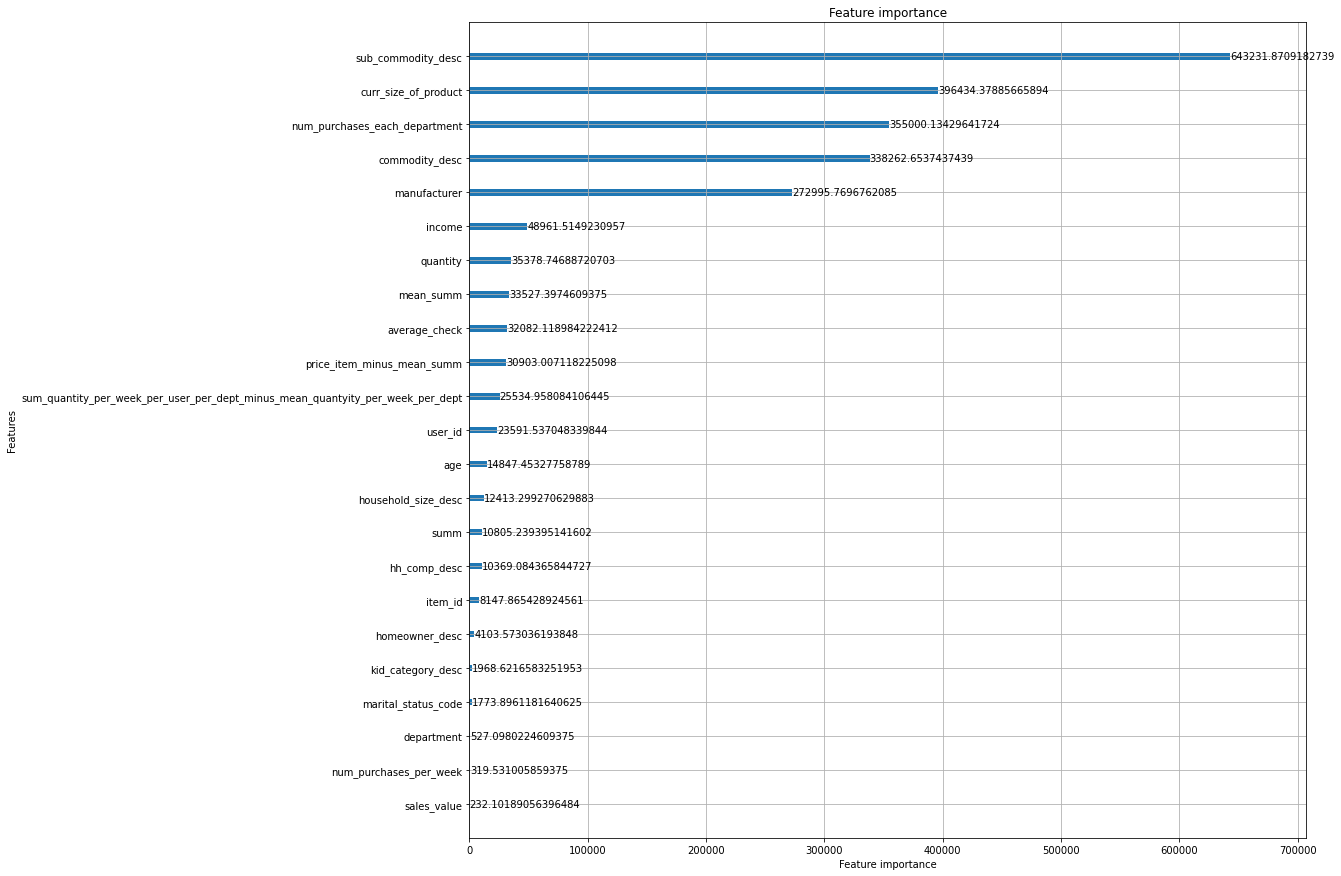

In [44]:
plot_importance(lgb, figsize=(15, 15), importance_type='gain')